## 0. Import Libraries

In [1]:
from glob import glob
from metpy.units import units
from shapely.geometry import mapping
from matplotlib.patches import Patch
from cartopy.feature import ShapelyFeature
from collections import Counter
from matplotlib.patches import Patch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import geopandas as gpd
import seaborn as sns
import cartopy.io.shapereader as shpreader 
import pymannkendall as mk

import rioxarray
import cartopy
import matplotlib
import proplot

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/__init__.py:30: ProplotWarning: Found conflicting default user proplot folders at '/home/donmezk16/.proplot' and '/home/donmezk16/.config/proplot'. Ignoring the second one.
  from .config import *  # noqa: F401 F403
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/__init__.py:30: ProplotWarning: Found conflicting default user proplot folders at '/home/donmezk16/.proplot' and '/home/donmezk16/.config/proplot'. Ignoring the second one.
  from .config import *  # noqa: F401 F403
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/__init__.py:30: Propl

## 1. Parameters

In [2]:
# general path
path_general = 'data'
name_var = 'cbh' # tp, t2m, blh, cbh

## 2. Open Data

UMD GLCF GLCDS lc: land cover data

### 2.1 LU Data

In [3]:
data_lu = rioxarray.open_rasterio(fr'{path_general}/land_use_data.tiff').squeeze()

In [4]:
data_lu.rio.crs

CRS.from_epsg(4326)

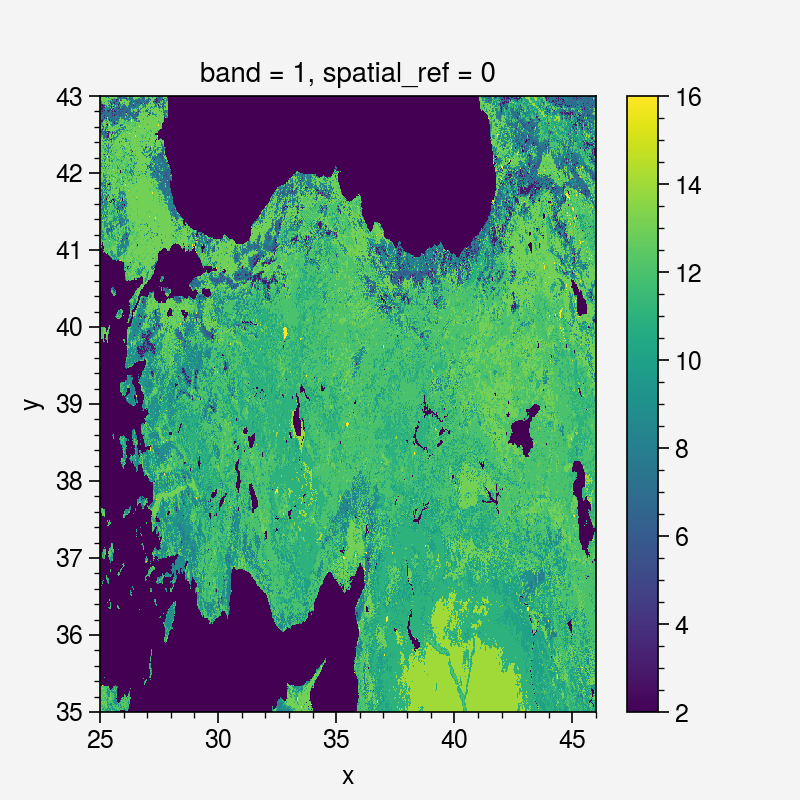

In [5]:
data_lu.plot()

### 2.2 ERA5 Data

In [6]:
if name_var == 'tp':
    data_sample = xr.open_dataset(fr'{path_general}/aggregated_{name_var}_era5_yearhour')[name_var].sum(dim='hour')
else:
    data_sample = xr.open_dataset(fr'{path_general}/aggregated_{name_var}_era5_yearhour')[name_var].mean(dim='hour')

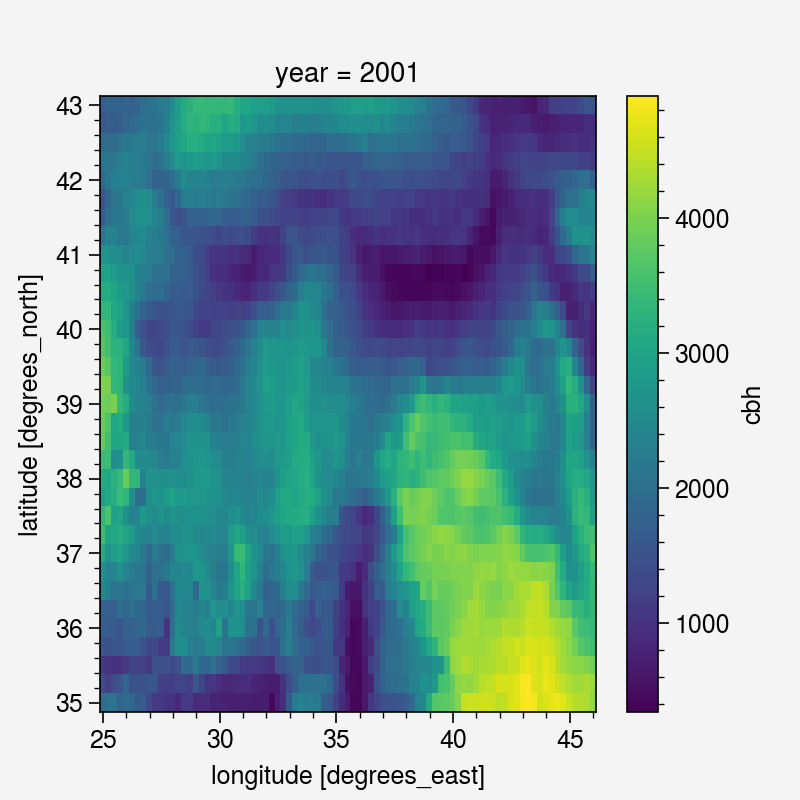

In [7]:
data_sample[0].plot()

## 3. Metadata Definition

In [8]:
def define_index_correspondence():
    
    indexes = {
        'water' : np.arange(0,3), # 1 to 11 included
        'Evergreen Needleleaf Forest' : np.arange(3,4), # 12 to 22 included
        'Evergreen Broadleaf Forest' : np.arange(4,5), # 23 to 34 included
        'Deciduous Needleleaf Forest' : np.arange(5,6), # 35 to 39 included
        'Deciduous Broadleaf Forest' : np.arange(6,7), # 40 to 45 included
        'Mixed Forest': np.arange(7,8), # all grids
        'Woodland': np.arange(8,9), # all but not water
        'Wooded Grassland': np.arange(9,10), # all but not water
        'Closed Shrubland': np.arange(10,11), # all but not water
        'Open Shrubland': np.arange(11,12), # all but not water
        'Grassland': np.arange(12,13), # all but not water
        'Cropland': np.arange(13,14), # all but not water
        'Bare Ground': np.arange(14, 15), # all but not water
        'Urban and Built-up': np.arange(15, 17), # all but not water
    }
    
    return indexes

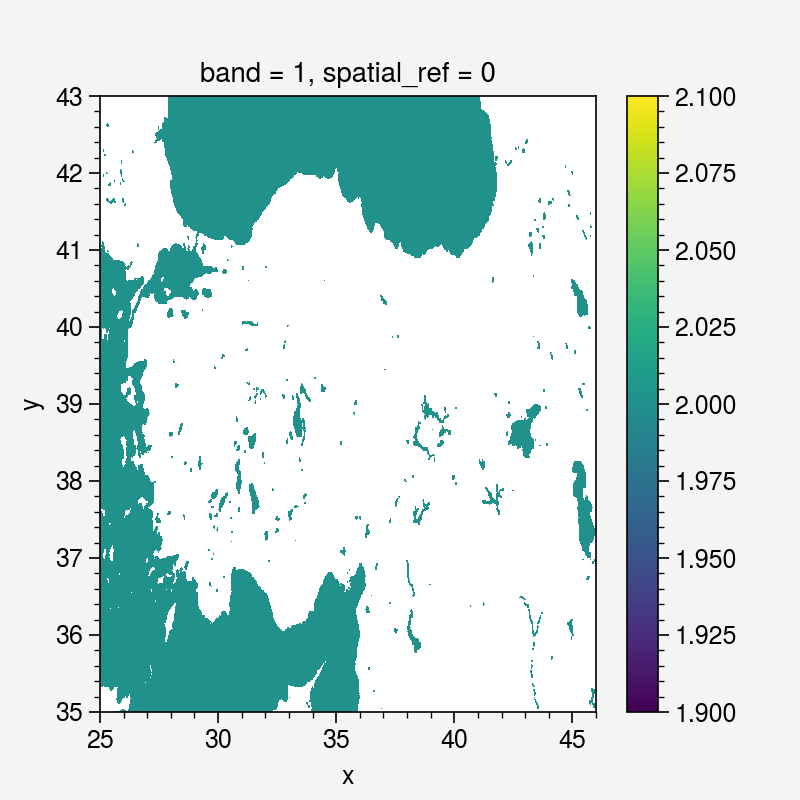

In [9]:
# define land-use index correspondence of name
indexes = define_index_correspondence()
index = 'water'

data_lu.where(data_lu.isin(indexes[index])).plot()

## 4. Regrid

In [10]:
# define globe
globe = cartopy.crs.Globe(ellipse='sphere',
                          semimajor_axis=6370000,
                          semiminor_axis=6370000)
# define observation projection
proj_obs = cartopy.crs.CRS('EPSG:4326',
                          )

# write projection
data_sample = data_sample.rio.write_crs(proj_obs)

# set spatial dims for ERA5
data_sample = data_sample.rio.set_spatial_dims(x_dim='longitude',
                                               y_dim='latitude')

# set spatial dims for land use data
data_lu = data_lu.rio.set_spatial_dims(x_dim='x',
                                       y_dim='y')


data_sample.rio.crs

CRS.from_epsg(4326)

In [11]:
def regrid_match(dt_to_match, dt_to_be_matched):
    
    """
    Regrid a file grid to a target grid. Requires input data array
    
    Return target file and regridded file
    
    """
    # reproject
    dt_to_be_matched = dt_to_be_matched.rio.reproject_match(dt_to_match)
    
    return dt_to_be_matched

In [12]:
dt_obs_regrid = regrid_match(data_lu, data_sample,
                             )
#dt_obs_regrid = dt_obs_regrid.unstack()

In [13]:
dt_obs_regrid

<xarray.DataArray 'cbh' (year: 20, y: 960, x: 2520)>
array([[[1669.4191, 1669.4191, 1669.4191, ..., 1484.6387, 1484.6387,
         1484.6387],
        [1669.4191, 1669.4191, 1669.4191, ..., 1484.6387, 1484.6387,
         1484.6387],
        [1669.4191, 1669.4191, 1669.4191, ..., 1484.6387, 1484.6387,
         1484.6387],
        ...,
        [1945.3934, 1945.3934, 1945.3934, ..., 4173.422 , 4173.422 ,
         4173.422 ],
        [1945.3934, 1945.3934, 1945.3934, ..., 4173.422 , 4173.422 ,
         4173.422 ],
        [1945.3934, 1945.3934, 1945.3934, ..., 4173.422 , 4173.422 ,
         4173.422 ]],

       [[1679.206 , 1679.206 , 1679.206 , ..., 1294.5514, 1294.5514,
         1294.5514],
        [1679.206 , 1679.206 , 1679.206 , ..., 1294.5514, 1294.5514,
         1294.5514],
        [1679.206 , 1679.206 , 1679.206 , ..., 1294.5514, 1294.5514,
         1294.5514],
...
        [1983.2565, 1983.2565, 1983.2565, ..., 5530.321 , 5530.321 ,
         5530.321 ],
        [1983.2565, 1983.2565, 1983.2565, ..., 5530.321 , 5530.321 ,
         5530.321 ],
        [1983.2565, 1983.2565, 1983.2565, ..., 5530.321 , 5530.321 ,
         5530.321 ]],

       [[1647.84  , 1647.84  , 1647.84  , ..., 2166.115 , 2166.115 ,
         2166.115 ],
        [1647.84  , 1647.84  , 1647.84  , ..., 2166.115 , 2166.115 ,
         2166.115 ],
        [1647.84  , 1647.84  , 1647.84  , ..., 2166.115 , 2166.115 ,
         2166.115 ],
        ...,
        [1418.1105, 1418.1105, 1418.1105, ..., 4242.0054, 4242.0054,
         4242.0054],
        [1418.1105, 1418.1105, 1418.1105, ..., 4242.0054, 4242.0054,
         4242.0054],
        [1418.1105, 1418.1105, 1418.1105, ..., 4242.0054, 4242.0054,
         4242.0054]]], dtype=float32)
Coordinates:
  * x            (x) float64 25.0 25.01 25.02 25.03 ... 45.97 45.98 45.99 46.0
  * y            (y) float64 43.0 42.99 42.98 42.97 ... 35.03 35.02 35.01 35.0
  * year         (year) int64 2001 2002 2003 2004 2005 ... 2017 2018 2019 2020
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38

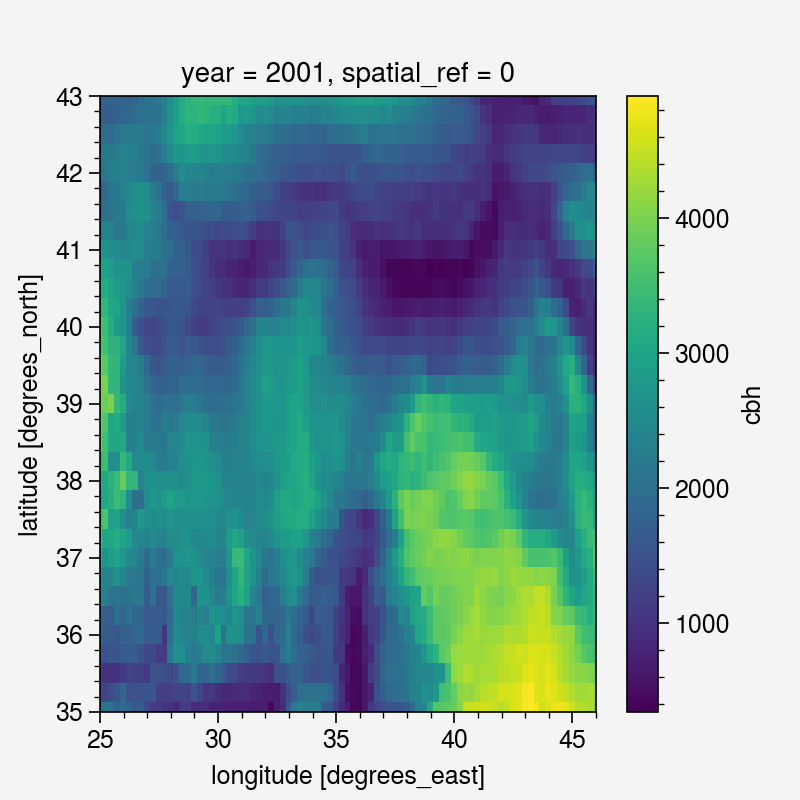

In [14]:
dt_obs_regrid[0].plot()

In [15]:
dt_obs_regrid.rio.crs

CRS.from_epsg(4326)

## 5. Clip to Turkey

In [16]:
def clip_to_city(data, shapefile):
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [17]:
shape_tr = gpd.read_file(fr'{path_general}/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp')

In [18]:
dt_obs_regrid_tr = clip_to_city(dt_obs_regrid, shape_tr)

# change nodata to np.nan
nodata = dt_obs_regrid_tr.rio.nodata
dt_obs_regrid_tr = dt_obs_regrid_tr.where(dt_obs_regrid_tr != nodata, np.nan)

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/rioxarray/raster_writer.py:108: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


## 6. Filter by Land Use

In [19]:
dict_lu_mask = {}

for index in list(indexes.keys()):
    
    if index not in ['Evergreen Broadleaf Forest',
                     'Deciduous Needleleaf Forest',
                    ]:
        data_sample_tr_reshaped = dt_obs_regrid_tr.where(data_lu.isin(indexes[index])).stack(spatial=('y', 'x')).values
        data_sample_tr_notisnan = data_sample_tr_reshaped[:, ~np.isnan(data_sample_tr_reshaped).any(axis=0)]
        
        # assign data
        dict_lu_mask[index] = data_sample_tr_notisnan.mean(axis=1)
        
        print('done', index)

done water
done Evergreen Needleleaf Forest
done Deciduous Broadleaf Forest
done Mixed Forest
done Woodland
done Wooded Grassland
done Closed Shrubland
done Open Shrubland
done Grassland
done Cropland
done Bare Ground
done Urban and Built-up


In [20]:
dict_lu_mask['water']

array([2412.4746, 2406.4873, 2522.6475, 2226.58  , 2260.8323, 2562.1506,
       2481.554 , 2619.416 , 2621.0874, 2454.74  , 2190.1904, 2534.2654,
       2274.3918, 2309.4504, 2366.6262, 2438.8835, 2487.4143, 2293.5146,
       2612.5916, 2480.779 ], dtype=float32)

## 7. Calculate Trend

In [21]:
trend_df = pd.DataFrame(dict_lu_mask)

In [22]:
trend_df

,water,Evergreen Needleleaf Forest,Deciduous Broadleaf Forest,Mixed Forest,Woodland,Wooded Grassland,Closed Shrubland,Open Shrubland,Grassland,Cropland,Bare Ground,Urban and Built-up
0,2412.474609,1031.362549,872.772095,939.078003,1402.740601,1744.283203,2573.085938,2805.599121,2191.739258,1839.283936,2930.122314,2153.116455
1,2406.487305,1161.278320,1050.257812,1095.612793,1542.660156,1893.696411,2498.656738,2585.741455,2061.127441,1841.977783,2580.132324,2146.822754
2,2522.647461,1151.834229,1000.550781,1072.426636,1601.151245,2041.683228,2612.035400,2725.371826,2135.874268,1828.924438,2952.061768,2267.218506
3,2226.580078,984.963257,889.890137,924.935791,1301.021240,1618.524292,2352.597900,2456.256592,1918.612793,1699.790283,2391.305176,1933.678223
4,2260.832275,985.818359,808.666870,860.860046,1330.753052,1689.084595,2353.260254,2508.997559,1962.996094,1659.809570,2639.349121,1985.472412
5,2562.150635,1155.540405,977.463684,1042.029297,1551.553711,1940.573975,2691.095215,2789.816162,2248.657959,1974.439453,2756.210938,2198.280273
6,2481.553955,1238.346313,1103.621582,1183.108521,1621.220459,1971.177490,2654.781006,2772.774658,2191.360840,1933.799805,2779.357666,2242.135498
7,2619.416016,1237.295410,1045.593872,1115.717163,1659.093140,2093.032715,2813.640381,2893.048584,2272.891357,1939.625488,2874.288574,2322.293945
8,2621.087402,1312.220581,1208.726685,1257.798096,1731.270508,2099.081787,2747.975098,2794.836670,2211.683350,1968.259521,2748.337158,2284.152832
9,2454.739990,1165.098633,1004.766602,1070.849976,1470.971191,1785.785156,2580.925781,2719.746338,2194.125000,1930.978638,2733.341064,2107.234131


### 7.1 Quick Plot

<AxesSubplot:>

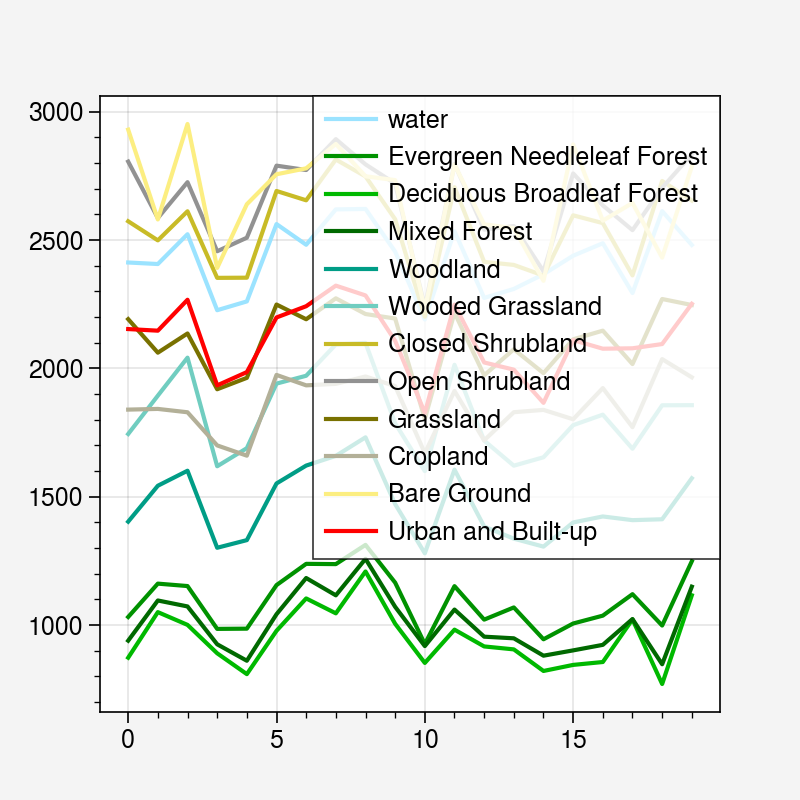

In [23]:
cb_list = [
    '#9be3ff',
    '#009200',
    '#00b900',
    '#006900',
    '#009d86',
    '#70cdc0',
    '#c8bb27',
    '#929292',
    '#797100',
    '#b3b098',
    '#fcee81',
    '#f00',
]

labels = ['water', 'Evergreen Needleleaf Forest',
       'Deciduous Broadleaf Forest', 'Mixed Forest', 'Woodland',
       'Wooded Grassland', 'Closed Shrubland', 'Open Shrubland',
       'Grassland', 'Cropland', 'Bare Ground', 'Urban and Built-up']

cmap = matplotlib.colors.ListedColormap(cb_list)

trend_df.plot(cmap=cmap)

### 7.2 Trend

In [24]:
trend_results = {}
for col in trend_df.columns:
    trend_results[col] = mk.original_test(trend_df[[col]], alpha=0.05)

In [25]:
trend_results_df = pd.DataFrame(trend_results,
                                index=['trend',
                                       'h',
                                       'p',
                                       'z',
                                       'Tau',
                                       's',
                                       'var_s',
                                       'slope',
                                       'intercept']).reset_index().rename(columns={'index':'type'})

In [26]:
trend_results_df

,type,water,Evergreen Needleleaf Forest,Deciduous Broadleaf Forest,Mixed Forest,Woodland,Wooded Grassland,Closed Shrubland,Open Shrubland,Grassland,Cropland,Bare Ground,Urban and Built-up
0,trend,no trend,no trend,no trend,no trend,no trend,no trend,no trend,no trend,no trend,no trend,no trend,no trend
1,h,False,False,False,False,False,False,False,False,False,False,False,False
2,p,0.721176,0.673189,0.417304,0.229969,0.922462,0.770288,0.871131,0.770288,0.537603,0.626496,0.256145,0.626496
3,z,0.356887,-0.421776,-0.811107,-1.200439,-0.097333,-0.291999,0.162221,-0.291999,0.616441,0.486664,-1.13555,-0.486664
4,Tau,0.063158,-0.073684,-0.136842,-0.2,-0.021053,-0.052632,0.031579,-0.052632,0.105263,0.084211,-0.189474,-0.084211
5,s,12.0,-14.0,-26.0,-38.0,-4.0,-10.0,6.0,-10.0,20.0,16.0,-36.0,-16.0
6,var_s,950.0,950.0,950.0,950.0,950.0,950.0,950.0,950.0,950.0,950.0,950.0,950.0
7,slope,2.414023,-1.775698,-5.527867,-4.909259,-1.656524,-2.449332,0.689699,-1.425384,2.69532,3.054181,-10.054379,-3.438017
8,intercept,2423.87855,1111.2141,999.538143,1035.573572,1433.285563,1825.943826,2570.453723,2725.205329,2115.78997,1811.616141,2784.38806,2141.303741


### 7.3 Save Data

In [27]:
trend_results_df.to_excel(fr'data/trend_data_{name_var}.xlsx', index=False)